In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas_profiling as pp
import seaborn as sns
import phik

In [2]:
# Road raw training data
raw_data = pd.read_csv('data/train.csv', index_col=0)
raw_data.head(5)

# Create copy not to work on raw data
data = raw_data.copy()
data.shape

(1460, 80)

In [3]:
# Exclude columns with > 20% missing values
threshold = 0.2
data = data[data.columns[data.isnull().mean() < threshold]]
data.shape

(1460, 75)

Types of data:
- numerical
    - discrete (e.g. number of bathrooms, age)
    - continuous (e.g. temperature, weight)
- categorical (e.g. color, type of material)
- ordinal (e.g. rating, university grade)  

In [4]:
interval_columns = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                   'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                   'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                   'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                   'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
                   'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                   'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
fake_interval_columns = ['MSSubClass', 'OverallQual', 'OveralCond', 'MoSold']

interval_columns = list(set(interval_columns) - set(fake_interval_columns))

In [5]:
# Calculate "correlation" between features and target
corr = data.phik_matrix(interval_cols=interval_columns)

<AxesSubplot:>

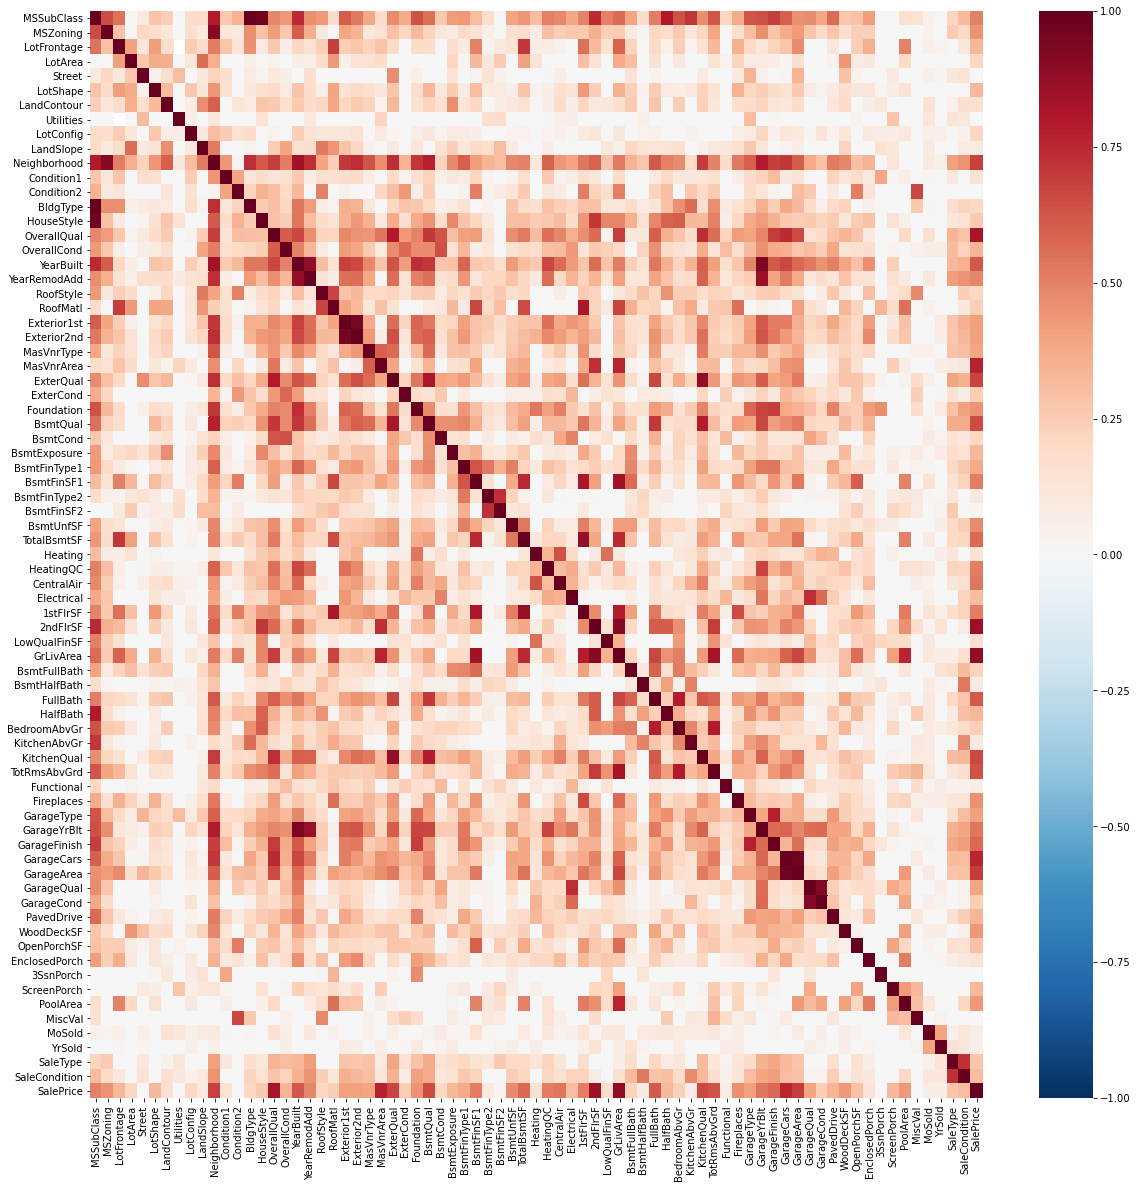

In [6]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')
sns.heatmap(corr, ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')

Show only correlations between SalePrice (target) and all other features.

In [7]:
corr_price = corr["SalePrice"]

# Show features with highest correlation with price
corr_price = corr_price.sort_values(ascending=False)
corr_price.head(5)

SalePrice      1.000000
GrLivArea      0.887026
2ndFlrSF       0.854449
OverallQual    0.820348
MasVnrArea     0.770451
Name: SalePrice, dtype: float64

Remove unimportant features

In [8]:
correlation_threshold = 0.3
features_to_keep = corr_price[corr_price > correlation_threshold].index

# Remove features weakly correlating with target 
data = data[features_to_keep]
data.shape

data_filtered = data.copy()
data_filtered.shape

(1460, 44)

### Deal with categorical data

In [9]:
non_interval_columns = set(data.columns) - set(interval_columns)
data[non_interval_columns].dtypes

ordinal_columns = ['HeatingQC', 'GarageQual', 'BsmtFinType1', 'ExterQual', 
                   'GarageFinish', 'BsmtExposure', 'LotShape', 'OverallQual',
                   'BsmtQual', 'KitchenQual']
categorical_columns = list(set(non_interval_columns) - set(ordinal_columns))

In [10]:
# Use One Hot Encoding for categorical columns
for column in categorical_columns: 
    data = pd.get_dummies(data, columns=[column], prefix=column, prefix_sep='_', 
                          drop_first=True)

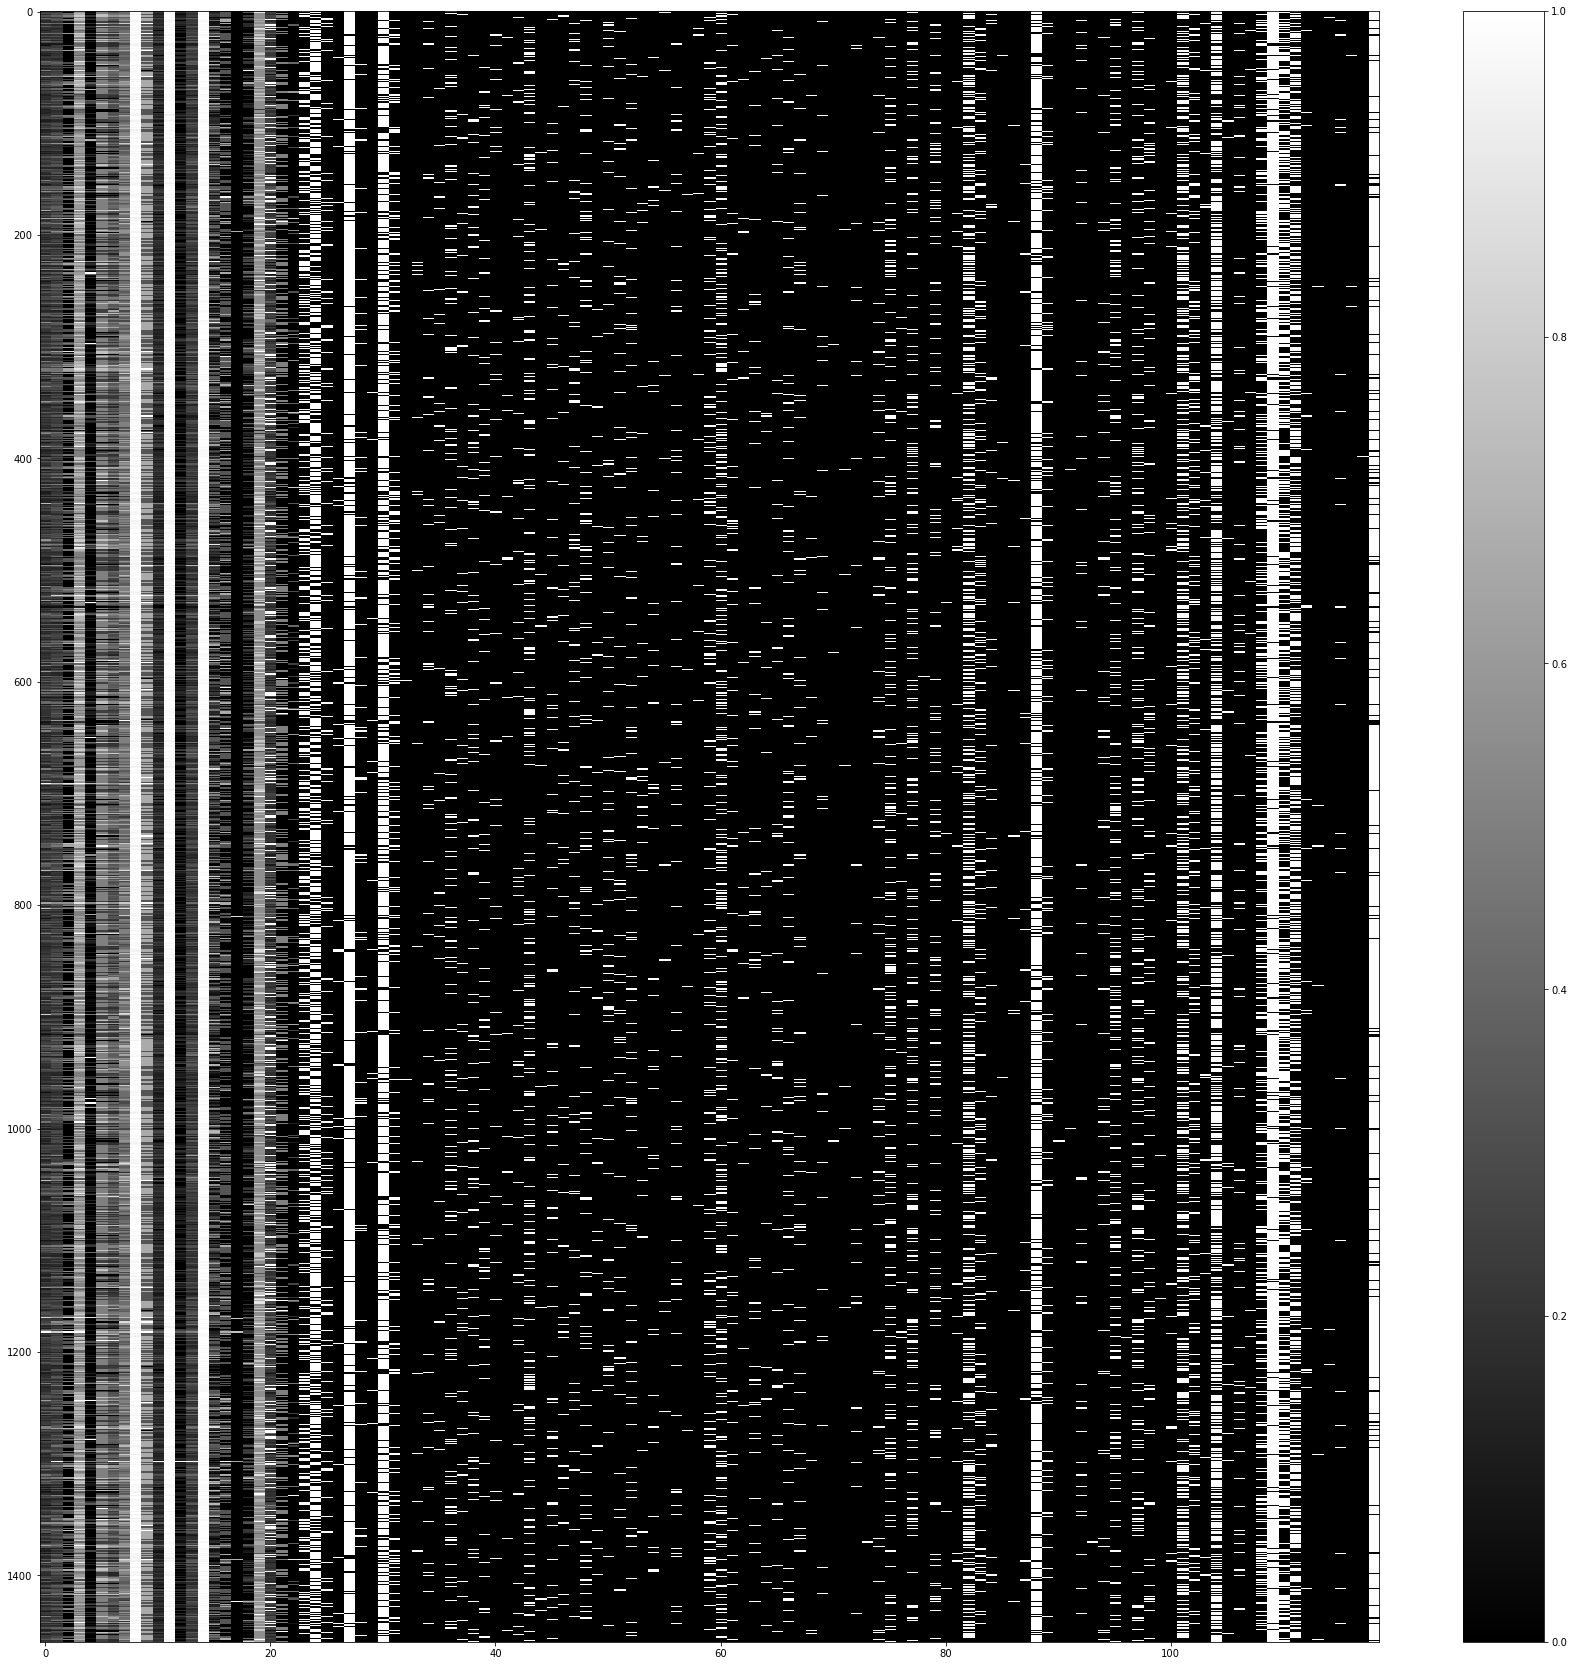

In [11]:
df = data.select_dtypes(['number'])
df = 1 - ((df.max() - df) / df.max())

fig, ax = plt.subplots(figsize=(30, 30), facecolor='w')
im = ax.imshow(df.values, aspect='auto', interpolation='none', cmap='gray')
plt.colorbar(im)

### Deal with ordinal data

In [12]:
for c in data[ordinal_columns]:
    print(c, data[c].unique())

HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
GarageFinish ['RFn' 'Unf' 'Fin' nan]
BsmtExposure ['No' 'Gd' 'Mn' 'Av' nan]
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']


In [13]:
# Using lambda syntax (less readability)
nan_column = lambda df, column: ~df[column].isna().astype(int)  

# Using def syntax
def nan_column(df, column):
    '''Creates column with ones and zeros encoding rows with nan.'''
    return ~df[column].isna().astype(int)

for column in ordinal_columns:
    if data[column].isna().any():
        print(f'Creating nan-encoding column for {column}')
        data[f'is{column}'] = nan_column(data, column)

Creating nan-encoding column for GarageQual
Creating nan-encoding column for BsmtFinType1
Creating nan-encoding column for GarageFinish
Creating nan-encoding column for BsmtExposure
Creating nan-encoding column for BsmtQual


In [14]:
# def mapping_from_list(order):
#     return {label: idx for idx, label in enumerate(order)}

# quality_mapping = mapping_from_list([np.nan, 'Po', 'TA', 'Gd', 'Ex'])

# quality_mapping_columns = ['HeatingQC', 'GarageQual', 'ExterQual', 
#                            'BsmtExposure', 'BsmtQual', 'KitchenQual']
# # for column in 
# data['HeatingQC'] = data['HeatingQC'].map(quality_mapping)
# data['GarageQual'] = data['GarageQual'].map(quality_mapping)
# data['ExterQual'] = data['ExterQual'].map(quality_mapping)
# data['BsmtExposure'] = data['BsmtExposure'].map(quality_mapping)
# data['BsmtQual'] = data['BsmtQual'].map(quality_mapping)
# data['KitchenQual'] = data['KitchenQual'].map(quality_mapping)

# data['LotShape'] = data['LotShape'].map(
#     mapping_from_list([np.nan, 'IR3', 'IR2', 'IR1', 'Reg']))

# data['BsmtFinType1'] = data['BsmtFinType1'].map(
#     mapping_from_list([np.nan, 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']))

In [15]:
def mapping_from_list(order):
    return {label: idx for idx, label in enumerate(order)}

# Features with ordinal data having same levels (Poor to Excelent)
quality_mapping = mapping_from_list([np.nan, 'Po', 'TA', 'Gd', 'Ex'])
quality_mapping_columns = ['HeatingQC', 'GarageQual', 'ExterQual', 
                           'BsmtExposure', 'BsmtQual', 'KitchenQual']

for column in quality_mapping_columns :
    data[column] = data[column].map(quality_mapping)

# Other features with ordinal data having weird levels :D
data['LotShape'] = data['LotShape'].map(
    mapping_from_list([np.nan, 'IR3', 'IR2', 'IR1', 'Reg']))

data['BsmtFinType1'] = data['BsmtFinType1'].map(
    mapping_from_list([np.nan, 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']))

data['GarageFinish'] = data['GarageFinish'].map(
    mapping_from_list([np.nan, 'Unf', 'RFn', 'Fin']))

In [30]:
data.select_dtypes(['number']).shape == data.shape

True